In [1]:
import bw2data as bd
import bw2calc as bc
import bw_processing as bwp
from pathlib import Path
from fs.zipfs import ZipFS
import matplotlib.pyplot as plt

# Electricity data
fp_entso_ts = "data/entso-timeseries.zip"

bw_project = "Correlated and dependent sampling"
bd.projects.set_current(bw_project)

In [2]:
# # Restore BW project
# bi.restore_project_directory(f"data/brightway2-project-Correlated and dependent sampling-backup.24-October-2022-08-13AM.tar.gz")
bd.databases

Databases dictionary with 3 object(s):
	biosphere3
	ecoinvent 3.8 cutoff
	swiss residual electricity mix

# Load ENTSO-E timeseries datapackage

In [3]:
# Note that these timeseries are given on an hourly basis for the years 2019, 2020 (leap year) and 2021. 
# First datapoint corresponds to 01.01.2019 00:00, and the last - to 31.12.2021 23:00.
dp_entso_ts = bwp.load_datapackage(ZipFS(fp_entso_ts))

data = dp_entso_ts.get_resource("timeseries ENTSO electricity values.data")[0]
indices = dp_entso_ts.get_resource("timeseries ENTSO electricity values.indices")[0]
flip = dp_entso_ts.get_resource("timeseries ENTSO electricity values.flip")[0]

# 1. All timeseries data VS data for only one country

## Select only one country

In [4]:
ei = bd.Database("ecoinvent 3.8 cutoff")
country = "BE"
markets = [act for act in ei 
           if "market for electricity" in act['name'] 
           and "waste" not in act['name']
           and country==act['location']
          ]
markets

['market for electricity, high voltage' (kilowatt hour, BE, None),
 'market for electricity, low voltage' (kilowatt hour, BE, None),
 'market for electricity, medium voltage' (kilowatt hour, BE, None)]

In [5]:
# Create a mask
mask = np.zeros(len(indices), dtype=bool)
for m in markets:
    mask = np.logical_or(mask, indices['col']==m.id)

In [6]:
# Create a datapackage for one country
dp_entso_ts_one_country = bwp.create_datapackage(sequential=True)
dp_entso_ts_one_country.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=indices[mask],
    data_array=data[mask],
    flip_array=flip[mask],
)

## Run Monte Carlo for the two cases

In [18]:
ei = bd.Database("ecoinvent 3.8 cutoff")

ch_low = [
    act for act in ei if act['name'] == "market for electricity, low voltage" and "CH" == act['location']
][0]
ipcc = ('IPCC 2013', 'climate change', 'GWP 100a')

fu, data_objs, _ = bd.prepare_lca_inputs({ch_low: 1}, method=ipcc, remapping=False)

iterations = 40
seed = 5555

In [19]:
%%time
# All time series
lca = bc.LCA(
    demand=fu, 
    data_objs=(
        data_objs + [dp_entso_ts]
    ),
    use_arrays=True,
    use_distributions=True,
    seed_override=seed,
)
lca.lci()
lca.lcia()

scores = [lca.score for _ in zip(range(iterations), lca)]

CPU times: user 2min 17s, sys: 3.97 s, total: 2min 21s
Wall time: 30.1 s


In [20]:
%%time
# Only one country
lca_country = bc.LCA(
    demand=fu, 
    data_objs=(
        data_objs + [dp_entso_ts_one_country]
    ),
    use_arrays=True,
    use_distributions=True,
    seed_override=seed,
)
lca_country.lci()
lca_country.lcia()

scores_country = [lca_country.score for _ in zip(range(iterations), lca_country)]

CPU times: user 2min 14s, sys: 3.78 s, total: 2min 18s
Wall time: 29.3 s


## Plot LCIA scores for both cases

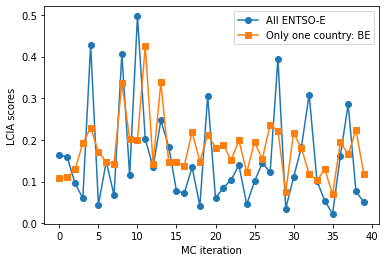

In [21]:
x = np.arange(iterations)

plt.plot(x, scores, "o-", label='All ENTSO-E')
plt.plot(x, scores_country, 's-', label=f'Only one country: {country}')
plt.xlabel('MC iteration')
plt.ylabel('LCIA scores')
plt.legend(loc="upper right")
plt.show()

# 2. All timeseries data VS data for only spring

## Select spring data in all three years

In [11]:
nmonths = 12  # month in one year
nhours = 24
days_2019 = 365
days_2020 = 366  # leap year
days_2019 = 365

# So here you just need to slice the data properly, and select only March, April and May in all years,
# given that different months and years have different number of days
nhours_spring = nhours*(31+30+31)
spring_start_2019 = nhours*(31+28)
spring_start_2020 = nhours*days_2019 + nhours*(31+29)  # leap year
spring_start_2021 = nhours*days_2019 + nhours*days_2020 + nhours*(31+28)

data_spring = np.hstack([
    data[:, spring_start_2019 : spring_start_2019 + nhours_spring],  # spring 2019
    data[:, spring_start_2020 : spring_start_2020 + nhours_spring ],  # spring 2020
    data[:, spring_start_2021 : spring_start_2021 + nhours_spring],  # spring 2021
])
data_spring.shape[1] == nhours_spring*3

True

In [12]:
# Create a datapackage for spring
dp_spring = bwp.create_datapackage(sequential=True)
dp_spring.add_persistent_array(
    matrix='technosphere_matrix',
    indices_array=indices,
    data_array=data_spring,
    flip_array=flip,
)

## Run Monte Carlo for the two cases

In [13]:
%%time
iterations = 1000

# All time series
lca = bc.LCA(
    demand=fu, 
    data_objs=(
        data_objs + [dp_entso_ts]
    ),
    use_arrays=True,
    use_distributions=True,
    seed_override=seed,
)
lca.lci()
lca.lcia()

scores = [lca.score for _ in zip(range(iterations), lca)]

CPU times: user 47min 27s, sys: 1min 7s, total: 48min 35s
Wall time: 9min 8s


In [14]:
%%time
# Only spring timeseries
lca_spring = bc.LCA(
    demand=fu, 
    data_objs=(
        data_objs + [dp_spring]
    ),
    use_arrays=True,
    use_distributions=True,
    seed_override=seed,
)
lca_spring.lci()
lca_spring.lcia()

scores_spring = [lca_spring.score for _ in zip(range(iterations), lca_spring)]

CPU times: user 47min 38s, sys: 1min 8s, total: 48min 47s
Wall time: 9min 8s


# Plot histograms of LCIA scores for both cases

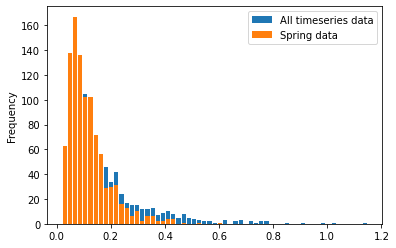

In [15]:
num_bins = 60

bins = np.linspace(min(scores + scores_spring), max(scores + scores_spring), num_bins, endpoint=True)
width = (bins[1]-bins[0])*0.8
midbins = (bins[1:]+bins[:-1])/2

freq_all, _ = np.histogram(scores, bins=bins, density=False)
freq_spr, _ = np.histogram(scores_spring, bins=bins, density=False)

plt.bar(midbins, freq_all, width=width, label="All timeseries data")
plt.bar(midbins, freq_spr, width=width, label="Spring data")
plt.ylabel('LCIA scores')
plt.ylabel('Frequency')
plt.legend(loc="upper right")